In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import pad_sequences

In [26]:
class TransformerEncoder(layers.Layer):
    
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        
        self.attention = layers.MultiHeadAttention(num_heads = self.num_heads, key_dim = self.embed_dim)
        self.dense_proj = keras.Sequential([
            layers.Dense(self.dense_dim, activation = 'relu'),
            layers.Dense(self.embed_dim)
        ])
        
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        
    def call(self, inputs, mask = None):
        
        if mask is not None:
            mask = maks[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs)
        proj_input = self.layernorm1(attention_output + inputs)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_output+ proj_input)
    
    def get_config(self):
        
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads
        })
        return config
        

In [27]:
vocab_size = 10000
embed_dim = 256
dense_dim = 32
num_heads = 2
max_words = 50

In [28]:
inputs = keras.Input(shape = (None, ), dtype = 'int64')
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim = embed_dim, dense_dim = dense_dim, num_heads = num_heads)(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.models.Model(inputs, outputs)

In [29]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 256)         2560000   
                                                                 
 transformer_encoder_3 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_3 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257 

In [30]:
from tensorflow.keras.datasets import imdb

In [31]:
import numpy as np
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocab_size)

In [32]:
x_train = pad_sequences(x_train, maxlen = max_words)
x_test = pad_sequences(x_test, maxlen = max_words)

In [33]:
x_train = tf.convert_to_tensor(x_train, np.int64)
x_test = tf.convert_to_tensor(x_test, np.int64)

In [34]:
y_train = tf.convert_to_tensor(y_train, np.int64)

In [35]:
x_val = x_train[:5000]
y_val = y_train[:5000]

In [36]:
x_train = x_train[5000:]
y_train = y_train[5000:]

In [37]:
callback_list = [
    keras.callbacks.ModelCheckpoint(
        "imdb_transformed_model.h5",
        metrics = 'val_acc',
        save_best_only = True
    )
]

In [38]:
model.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)
history = model.fit(
    x_train,
    y_train,
    epochs = 20,
    batch_size = 128,
    validation_data = (x_val, y_val),
    callbacks = callback_list
)

Epoch 1/20
 12/157 [=>............................] - ETA: 55s - loss: 1.6263 - acc: 0.5117

KeyboardInterrupt: 

In [18]:
hist = history.history

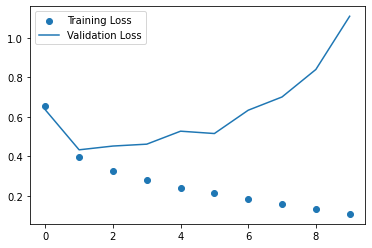

In [19]:
import matplotlib.pyplot as plt
plt.scatter(range(len(hist['loss'])), hist['loss'], label = 'Training Loss')
plt.plot(range(len(hist['val_loss'])), hist['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()